**Description**
**Background and Context**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

**Objective**

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

**Data Description**

This dataset contains images of unique plants belonging to 12 different species.

**The data file names are:**
images.npy
Label.csv
Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.

The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Plant species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## **Importing the necessary libraries**

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Reading the dataset**

In [ ]:
# Mount Google drive to access the dataset 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Project8/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Project8/Labels.csv')

## **Overview of the dataset**


Let's print the shape of the images and labels 

In [ ]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Plotting images using OpenCV and matplotlib

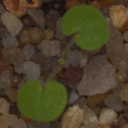

In [ ]:
cv2_imshow(images[5])

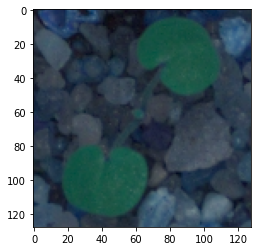

In [ ]:
plt.imshow(images[5])

- We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- Now we will convert these BGR images to RGB images so we could interpret them easily.

In [ ]:
# # Converting the images from BGR to RGB using cvtColor function of OpenCV
images_rgb=[]
for i in range(len(images)):
  images_rgb.append(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

images_rgb = np.asarray(images_rgb)

## **Exploratory Data Analysis** 

In [ ]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 4                                                                        # Defining number of rows=3
  cols = 6                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(16, 14))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

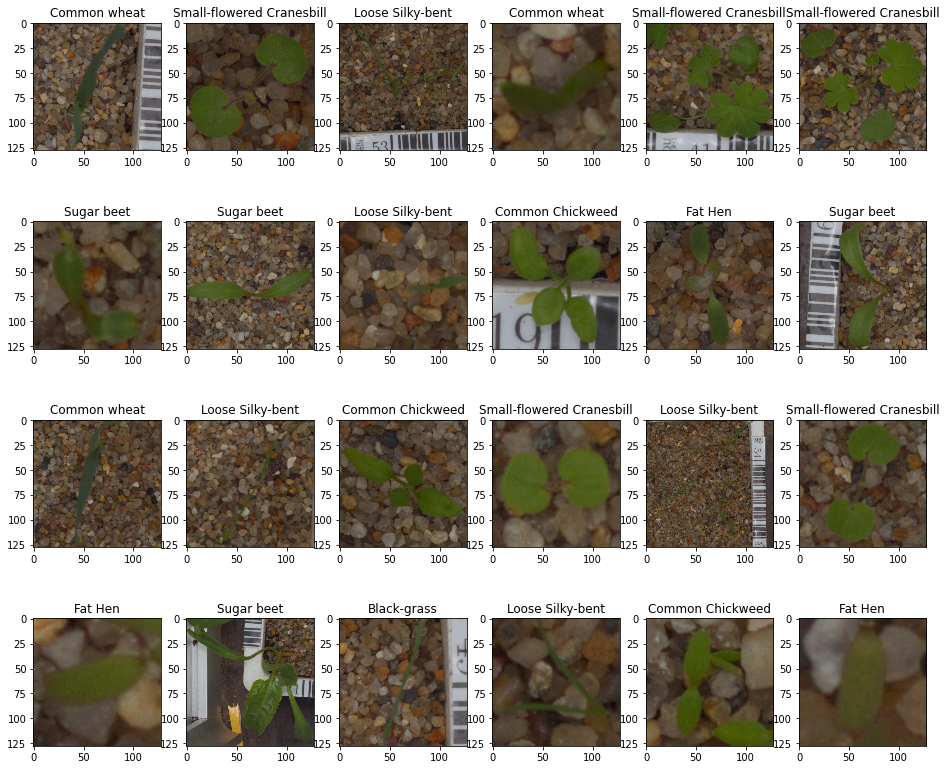

In [ ]:
plot_images(images_rgb,labels)

**Key meaningful Observations from EDA:**

* Charlock, Small-flowered Carnesbill and Scentless Mayweed have similar patterns  like a round shaped leaf, similar in length and width. Similar color with slight variation in the intensity of green shade on the leafs.
* Fat Hen, Loose Silky-bent, Common Wheat and Black grass leafs are look longer and thin in the width.
* Common Wheat, Silky bent, and Blackgrass possess a similar kind of structure, their width is narrower and the length of the leaf is longer as compared to others. It's a kind of grass, not a leaf.
* Sugarbeet, Maize and Common Chickweed have a similar kind of structure, where the length of the leaves is more but the width is less.


<b> Checking for data imbalance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

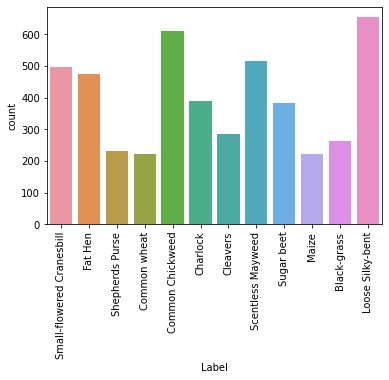

In [ ]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

**Observations:**
- As you can see from the above plot, the dataset is quite imbalanced. 
- **Small-flowered Cranesbill, Fat-Hen, Common Chickweed, Scentless Mayweed and Loose Silky** beet have 500 or more images.
-  Rest of the categories have images between 200 and 400. 

##Data Pre - Processing

### Resizing images and Preserving the Aspect Ratio of the Image
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

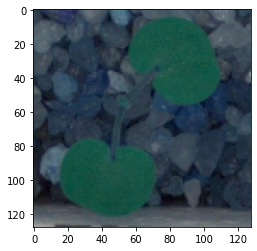

In [ ]:
plt.imshow(images[4])

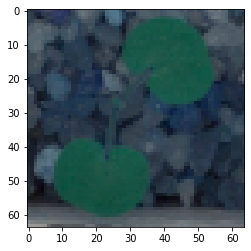

In [ ]:
plt.imshow(images_decreased[4])

### Remove unwanted noise from the images using Gaussian Blurring

The ‘GaussianBlur’ function from the Open-CV package can be used to implement a Gaussian filter. The function allows you to specify the shape of the kernel. You can also specify the the standard deviation for the x and y directions separately. If only one sigma value is specified then it is considered the sigma value for both the x and y directions.

In [ ]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images_decreased)):
  images_gb.append(cv2.GaussianBlur(images_decreased[i], ksize =(5,5),sigmaX =  0))


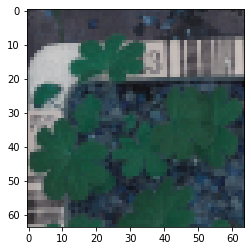

In [ ]:
plt.imshow(images_decreased[3])

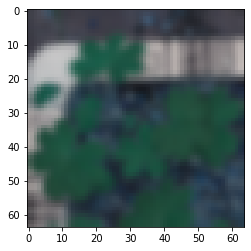

In [ ]:
plt.imshow(images_gb[3])

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images. We can try GaussianBlur by converting the image to HSV and applying masking to get a better image.

### Converting from RGB to HSV

- Here, the **cv2.COLOR_BGR2HSV** conversion code is used in the **cvtColor()** function to convert our image to the HSV color scheme.
- The HSV color scheme finds great use in performance-critical Computer Vision tasks, such as object detection for images with poor lighting, because the various objects in an image may not be clearly distinguishable in normal RGB colors, and the HSV color scheme enhances the ability to detect separate entities and patterns in such images.

In [ ]:
images_hsv = []
for i in range(len(images_gb)):
  images_hsv.append(cv2.cvtColor(images_gb[i], cv2.COLOR_BGR2HSV))

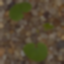

In [ ]:
cv2_imshow(images_gb[6])

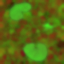

In [ ]:
cv2_imshow(images_hsv[6])

**Observations:**
- As we can see from the above image, the green leafs are more prominent on the HSV image than the original image.

### Masking

In [ ]:
lower = (24,20,20)
upper = (75,255,255)
# Applying mask
images_mask=[]
for image in  images_hsv: #range(len(images_hsv)):
    mask = cv2.inRange(image ,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) #getting structring element ( kernal) of sie 11x11
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    imask = mask>0
    green = np.zeros_like(image,np.uint8)
    green[imask] = image[imask]
    images_mask.append(green)
images_mask = np.asarray(images_mask)

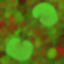

In [ ]:
cv2_imshow(images_hsv[100])

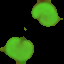

In [ ]:
cv2_imshow(images_mask[100])

**Observation:**
- From the above image we can see that masking has helped to make the leafs of the plant more prominent and thus it might help reduce noise.

In [ ]:
image_final = np.asarray(images_mask)

### Plot the images before and after the pre-processing steps

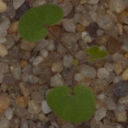

In [ ]:
cv2_imshow(images[6])

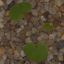

In [ ]:
cv2_imshow(images_decreased[6])

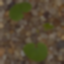

In [ ]:
cv2_imshow(images_gb[6])

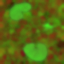

In [ ]:
cv2_imshow(images_hsv[6])

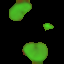

In [ ]:
cv2_imshow(images_mask[6])

**Observations:**
- From the above images we can see the gradual changes happened after data processing, applying gradient blur, converting the image to HSV and applying masking has given a good result in the data. Let us see how our models perform.

## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values


## Encoding the target labels

In [ ]:
# Convert labels from names to one hot vectors.
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
targetY = enc.fit_transform(labels)

In [ ]:
print(targetY.shape)
print(image_final.shape)

(4750, 12)
(4750, 64, 64, 3)


## **Splitting the dataset**

- As we have less images in our dataset, we will only use 10% of our data for testing and 90% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset while keeping the test size constant at 0.1. This means that 10% of total data is used for testing, while 90% is used for training. 
- I am using **stratify** to get an equal distribution of classes in the test and train set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(image_final),targetY , test_size=0.1, random_state=42,stratify=targetY)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4275, 64, 64, 3) (4275, 12)
(475, 64, 64, 3) (475, 12)


## Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## **Model Building - Convolutional Neural Network (CNN)**

Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session. 

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

### <b> Fitting the model on the train data

In [ ]:
history_1 = model.fit(
            X_train_normalized, y_train,
            epochs=30,
            validation_split=0.1,
            # shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 4s - loss: 2.0904 - accuracy: 0.2389 - val_loss: 1.7936 - val_accuracy: 0.3855 - 4s/epoch - 31ms/step
Epoch 2/30
121/121 - 2s - loss: 1.7369 - accuracy: 0.3871 - val_loss: 1.5456 - val_accuracy: 0.4276 - 2s/epoch - 13ms/step
Epoch 3/30
121/121 - 2s - loss: 1.5696 - accuracy: 0.4359 - val_loss: 1.4533 - val_accuracy: 0.4977 - 2s/epoch - 13ms/step
Epoch 4/30
121/121 - 2s - loss: 1.4408 - accuracy: 0.4754 - val_loss: 1.2703 - val_accuracy: 0.5678 - 2s/epoch - 13ms/step
Epoch 5/30
121/121 - 2s - loss: 1.3047 - accuracy: 0.5168 - val_loss: 1.2029 - val_accuracy: 0.5981 - 2s/epoch - 13ms/step
Epoch 6/30
121/121 - 2s - loss: 1.2107 - accuracy: 0.5529 - val_loss: 1.1949 - val_accuracy: 0.5911 - 2s/epoch - 13ms/step
Epoch 7/30
121/121 - 2s - loss: 1.1709 - accuracy: 0.5662 - val_loss: 1.1496 - val_accuracy: 0.6121 - 2s/epoch - 12ms/step
Epoch 8/30
121/121 - 2s - loss: 1.0596 - accuracy: 0.6012 - val_loss: 1.0434 - val_accuracy: 0.6495 - 2s/epoch - 13ms/step
Epoch 9/30
121/1

### **Model Evaluation**

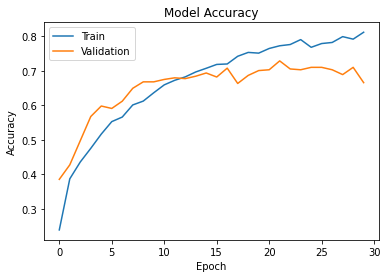

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 


*   We can see from the above plot that **the training accuracy of the  model was good but the validation accuracy was not good.**
*   The model seems to overfit on the data after the 12th EPOCH.






### **Evaluating the model on test data**

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test, verbose=2)

15/15 - 0s - loss: 1.2345 - accuracy: 0.7032 - 135ms/epoch - 9ms/step


### **Generating the predictions using test data**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [ ]:
y_pred

array([[1.86826055e-10, 7.42179566e-07, 5.23759581e-07, ...,
        4.47681686e-03, 9.24756365e-13, 1.10057533e-06],
       [1.36089921e-02, 6.12169833e-06, 3.81127256e-03, ...,
        5.33379149e-04, 1.03251905e-05, 4.94263694e-02],
       [1.22654924e-07, 4.97688642e-14, 3.45280817e-08, ...,
        4.95073582e-05, 1.20811346e-04, 7.11910665e-01],
       ...,
       [2.22806022e-25, 9.19688046e-01, 1.20350169e-02, ...,
        5.15027866e-02, 1.67444441e-02, 1.70692983e-05],
       [7.06409993e-17, 7.98294861e-13, 1.67969020e-07, ...,
        1.30402434e-04, 9.99837875e-01, 3.05923095e-05],
       [2.93540664e-10, 1.58633939e-05, 1.53442521e-08, ...,
        7.00434968e-02, 9.80037296e-09, 1.62460736e-07]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





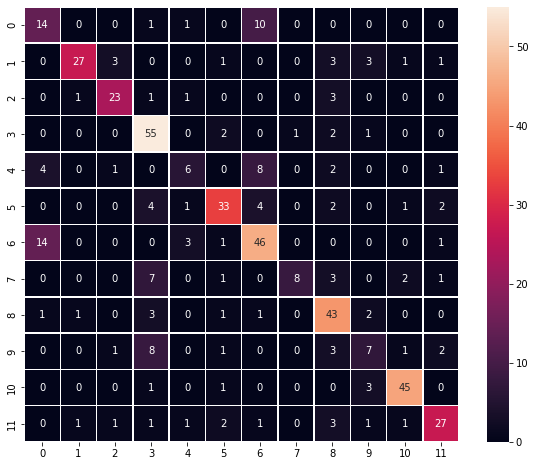

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- Most of the classes are predicted correctly. 
- In comparison to the rest, we can see that classes 3,8,6 and 10 are well classified.
- We can also observe that classes 7,7 and 9 are mostly misclassified.

# Model-2

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

## **Data Augmentation**

In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test),
                    verbose=2)

Epoch 1/25
66/66 - 7s - loss: 2.0393 - accuracy: 0.2788 - val_loss: 2.3375 - val_accuracy: 0.3053 - 7s/epoch - 104ms/step
Epoch 2/25
66/66 - 6s - loss: 1.6037 - accuracy: 0.4365 - val_loss: 2.1947 - val_accuracy: 0.3958 - 6s/epoch - 84ms/step
Epoch 3/25
66/66 - 5s - loss: 1.3036 - accuracy: 0.5431 - val_loss: 1.9540 - val_accuracy: 0.5516 - 5s/epoch - 83ms/step
Epoch 4/25
66/66 - 6s - loss: 1.1322 - accuracy: 0.6041 - val_loss: 1.8812 - val_accuracy: 0.3895 - 6s/epoch - 84ms/step
Epoch 5/25
66/66 - 5s - loss: 1.0594 - accuracy: 0.6281 - val_loss: 1.5113 - val_accuracy: 0.6316 - 5s/epoch - 83ms/step
Epoch 6/25
66/66 - 6s - loss: 1.0030 - accuracy: 0.6493 - val_loss: 1.5034 - val_accuracy: 0.5032 - 6s/epoch - 84ms/step
Epoch 7/25
66/66 - 6s - loss: 0.9249 - accuracy: 0.6604 - val_loss: 1.1520 - val_accuracy: 0.7200 - 6s/epoch - 84ms/step
Epoch 8/25
66/66 - 5s - loss: 0.8502 - accuracy: 0.6994 - val_loss: 0.8787 - val_accuracy: 0.7074 - 5s/epoch - 83ms/step
Epoch 9/25
66/66 - 6s - loss: 0

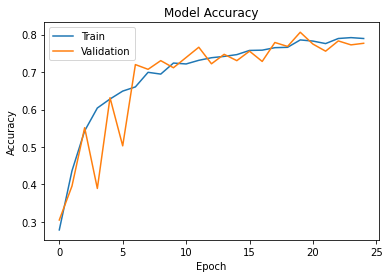

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test, verbose=2)

15/15 - 0s - loss: 0.7242 - accuracy: 0.7768 - 134ms/epoch - 9ms/step


We can observe that our accuracy has improved compared to our previous model.

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

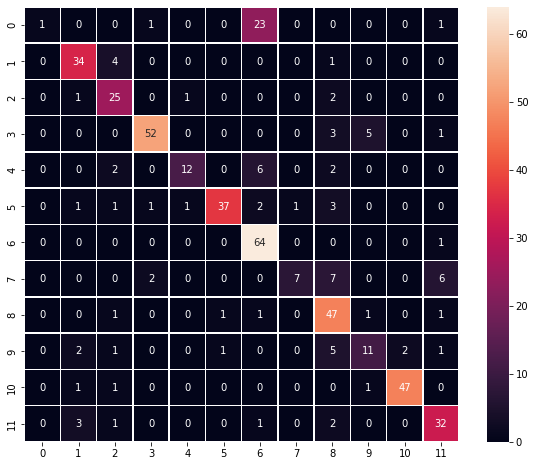

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observation:**
- The confusion matrix appears to be improving as well, there is a slight improvement in class 7, 9 and 4.
- The 6th class is the most confused class among all.
- We can observe that this model has outperformed our previous model.

# Transfer Learning using VGG16

- Let's try again, but this time, we will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 32)                65568     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 12)                204       
                                                                 
Total params: 14,780,988
Trainable params: 66,300
Non-

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test),
                    verbose=1)

Epoch 1/25
66/66 [==============================] - 13s 171ms/step - loss: 2.1164 - accuracy: 0.2782 - val_loss: 1.6729 - val_accuracy: 0.4632
Epoch 2/25
66/66 [==============================] - 13s 205ms/step - loss: 1.6383 - accuracy: 0.4362 - val_loss: 1.3344 - val_accuracy: 0.5474
Epoch 3/25
66/66 [==============================] - 8s 115ms/step - loss: 1.4308 - accuracy: 0.4961 - val_loss: 1.1897 - val_accuracy: 0.6000
Epoch 4/25
66/66 [==============================] - 7s 113ms/step - loss: 1.2907 - accuracy: 0.5400 - val_loss: 1.0743 - val_accuracy: 0.6463
Epoch 5/25
66/66 [==============================] - 7s 112ms/step - loss: 1.1979 - accuracy: 0.5811 - val_loss: 1.0162 - val_accuracy: 0.6274
Epoch 6/25
66/66 [==============================] - 7s 113ms/step - loss: 1.1231 - accuracy: 0.6025 - val_loss: 0.9557 - val_accuracy: 0.6758
Epoch 7/25
66/66 [==============================] - 7s 112ms/step - loss: 1.0762 - accuracy: 0.6243 - val_loss: 0.9223 - val_accuracy: 0.6926
Epoc

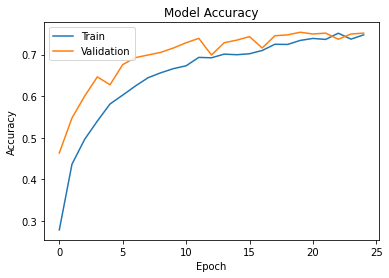

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = new_model.evaluate(X_test_normalized, y_test, verbose=2)

15/15 - 1s - loss: 0.7318 - accuracy: 0.7516 - 624ms/epoch - 42ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

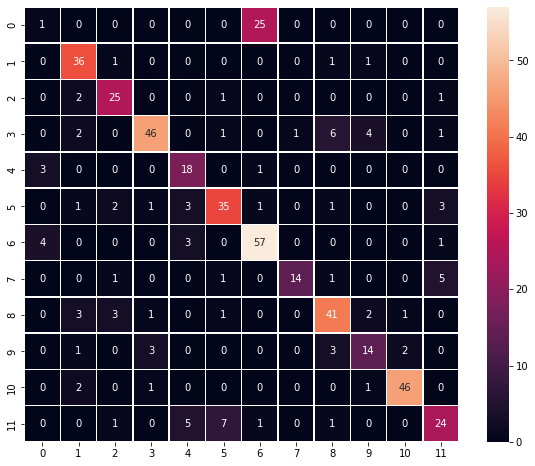

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- According to the confusion matrix and accuracy curve, the VGG16 model and Model-2 have a similar performance with a very mior difference in their accuracy values.
- Thus we can say that Model-2 is our best model and we can use this model to predict and visualize some test images.

# **Visualizing the prediction:**

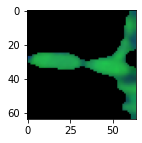

Predicted Label ['Fat Hen']
True Label Fat Hen


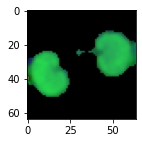

Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


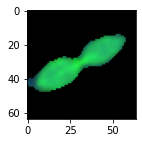

Predicted Label ['Common Chickweed']
True Label Common Chickweed


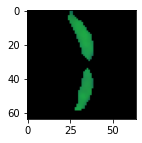

Predicted Label ['Fat Hen']
True Label Fat Hen


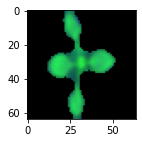

Predicted Label ['Common Chickweed']
True Label Common Chickweed


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[42],)
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[42].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[42]) 

plt.figure(figsize=(2,2))
plt.imshow(X_test[82],)
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[82].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[82])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[100])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[100].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[100])                                              # using inverse_transform() to get the output label from the output vector

## Conclusion and Key Insights
- We can observe from the confusion matrix of all the models that our second model was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the second model is 78%.
- Data Augmentation has also helped in improving the model.
- Although VGGnet did not outperform Model-2, it is evident that simply employing the transfer learning model can produce a better outcome than any ordinary CNN.
-**There is still scope for improvement in the test accuracy of the CNN model** chosen here. **Different architectures** and **optimizers** can be used to built to obtain a better classification of plants.

## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters. 
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.